In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn

from utils import flat_to_triangular, make_cholesky, plot

np.random.seed(3)

### $D$-dimensional features, scalar regression target, with covariance

### Problem

We consider a regression problem with D-dimensional features $x$, scalar targets $t$ and unknown variance $\sigma^2$. We wish to learn a bayesian linear model with learnt basis functions. 

### Case of the known basis function

In the case of a known deterministic D-dimensional basis function $\phi$, the likelihood is:

\begin{align}
p(t\ |\ a, b, x; \sigma^2) & = \mathcal{N}(a \phi(x) + b, \sigma^2) 
\end{align}

We define the prior over the parameters as an isotropic Gaussian, which gives:

\begin{align}
 p(a) = \mathcal{N}(0,1) \qquad  p(b) = \mathcal{N}(0,1)
\end{align}

It is then possible to compute the posterior of parameters analytically, given $(\mathbf{x}, \mathbf{t})$ the entire dataset:

\begin{align}
p(a,b |\mathbf{t} , \mathbf{x}; \sigma^2) = \frac{p(\mathbf{t} | a, b, \mathbf{x}; \sigma^2) p(a,b)}{p(\mathbf{t} | \mathbf{x}; \sigma^2)}
\end{align}

The denominator $p(\mathbf{t} | \mathbf{x}; \sigma^2)$ is tractable and constant, hence we can also approximate the posterior using our favorite MCMC methods.


### Learnt basis function

#### Bayes by Backprop

We take as basis function $f_\theta$ a NN parameterized by $\theta$. We optimize $\theta$ and $\sigma^2$ using maximum likelihood and $a, b$ using Variational Inference, which allows us to derive a lower bound of the marginal log likelihood (with regards to $a,b$) that we can optimize end-to-end. We have:

\begin{align}
\log p(\mathbf{t} | \mathbf{x}; \sigma^2, \theta) & = \log \int_{a,b} p(\mathbf{t}, a, b | \mathbf{x}; \sigma^2, \theta) dadb \\
& = \log \int_{a,b} p(\mathbf{t} | a, b, \mathbf{x}; \sigma^2, \theta)p(a,b) dadb \\
& = \log \int_{a,b} q(a,b) p(\mathbf{t} | a, b, \mathbf{x}; \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} dadb \\
& \geq \mathbb{E}_{q(a,b)} \left[ \log  p(\mathbf{t} | a, b, \mathbf{x}; \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} \right] \\
& = \mathbb{E}_q[\log p(\mathbf{t}\ |\ a, b, \mathbf{x}; \theta, \sigma^2)] - \mathrm{KL}(q(a,b) \ ||\ p(a,b)) \\
&= \mathcal{L (t, x)}
\end{align}

#### Modelling the posterior of vector quantities with covariance

In this context, $a$ is a vector of size $D$ and $b$ a scalar. We denote as $v$ the vector representing all the concatenated parameters $a$ and $b$, with size $D'=D+1$. In this context, we choose to model the approximate posterior of $v$ using a **Multivariate Gaussian** where the covariance matrix $\boldsymbol{\Sigma}$ is parametrized by a Cholesky factor $\mathbf{L}$, which allows us to apply the reparametrization trick [[Pathwise Derivatives Beyond the Reparameterization Trick]](https://arxiv.org/pdf/1806.01851.pdf):

\begin{align}
\boldsymbol{\Sigma} &= \mathbf{L} \mathbf{L}^T\\
\mathbf{y} & \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \\
\mathbf{y} &= \boldsymbol{\mu} + \mathbf{L} \boldsymbol{\epsilon} \\
\boldsymbol{\epsilon} &\sim \mathcal{N}(0, \mathbf{I})
\end{align}

The mean of $\mathbf{y}$ is trivially $\boldsymbol{\mu}$, while the covariance is indeed $\boldsymbol{\Sigma}$:

\begin{aligned}
\mathrm{cov} (\mathbf{y}) &=\mathbb{E}\left[(\mathbf{y}-\mathbb{E}[\mathbf{y} ])(\mathbf{y}-\mathbb{E}[\mathbf{y} ])^{T}\right] \\ 
&=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon}(\mathbf{L} \boldsymbol{\epsilon})^{T}\right] \\ 
&=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T} \mathbf{L}^{T}\right] \\ 
&=\mathbf{L} \mathbb{E}\left[\boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T}\right] \mathbf{L}^{T} \\ 
&=\mathbf{L} \mathbf{L}^{T} = \boldsymbol{\Sigma}
\end{aligned}

The two terms we need to compute the ELBO are as follows:

\begin{split}
\mathbb{E}_q[\log p(\mathbf{t}\ |\ a, b, \mathbf{x} ; \theta, \sigma^2)] &=  \mathbb{E}_q \left[ \sum_{i = 1}^N \left[ -\frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} [(t_i - a f_{\theta}(x_i) - b)^2] + \mathrm{const.} \right] \right] \\
\mathrm{KL}(q(v) \ ||\ p(v)) &= -\frac{1}{2} \sum_{i=1}^{D'} \left(1 + \log L_{i,i}^2 - \mu_i^2 - \Sigma_{i,i}\right)
\end{split}
where $N$ is the data set size.

Here we used the KL divergence between multivariate Gaussian distributions:
\begin{aligned}
\mathrm{KL}(q\ ||\ p))
    &= \frac{1}{2} \left( \log |\boldsymbol{\Sigma}_ p| - \log |\boldsymbol{\Sigma}_ q| - D' + \mathrm{tr} (\boldsymbol{\Sigma}_p^{-1} \boldsymbol{\Sigma}_q) + (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)^T  \boldsymbol{\Sigma}_p (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)\right) \\
    & = \frac{1}{2} \left( - \log \left(|\boldsymbol{L}|^2\right) - D' + \mathrm{tr} (\boldsymbol{\Sigma}_q) +  \boldsymbol{\mu}_q^T \boldsymbol{\mu}_q\right) \\
    & = -\frac{1}{2} \left(D' + \sum_{i=1}^{D'} \log L_{ii}^2 - \sum_{i=1}^{D'} (\boldsymbol{\Sigma}_q)_{ii} - \sum_{i=1}^{D'} \mu_i^2 \right)
\end{aligned}

### Papers

[Gaussian variational approximation with a factor covariance structure](https://arxiv.org/pdf/1701.03208.pdf)

[Pathwise Derivatives Beyond the Reparameterization Trick](https://arxiv.org/pdf/1806.01851.pdf)

[Berkley Kingma ppt](https://berkeley-deep-learning.github.io/cs294-131-s17/slides/VAE%20talk.compressed.pdf)

### Toy Dataset 1

f shape: (50, 3)
a shape: (3, 1)


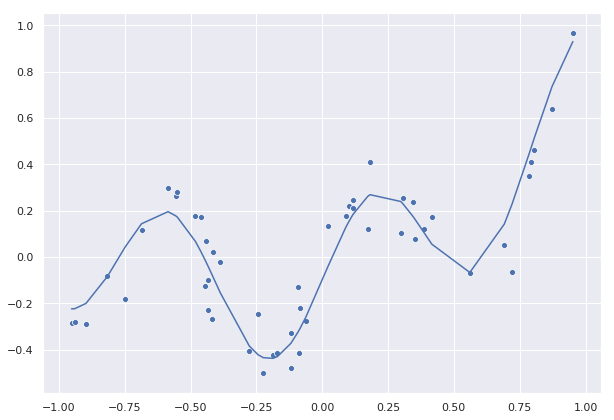

In [2]:
N = 50
true_a = np.array([.3, .5, .3]).reshape(-1, 1)
true_b = np.asarray(0.2)
sigma = 0.1  # observation noise
# x = np.linspace(-1, 1, N).reshape(-1, 1)
x = (np.random.rand(N) * 2 - 1).reshape(-1, 1)
x.sort(axis=0)
fx1 = x - 1
fx2 = x**2
fx3 = np.sin(8 * x)
fx = np.concatenate((fx1, fx2, fx3), axis=-1)
print('f shape:', fx.shape)
print('a shape:', true_a.shape)
t = fx @ true_a + true_b + sigma*np.random.randn(*x.shape)  # observations
plt.figure(figsize=(10, 7))
plt.plot(x, fx @ true_a + true_b)
# plt.plot(x, fx, alpha=0.3)
sns.scatterplot(x[:, 0], t[:, 0])
plt.show() 

x = torch.tensor(x, dtype=torch.float)
t = torch.tensor(t, dtype=torch.float)

### Features extractor and stochastic layer

Define function $f_{\theta}$ to extract features $h = f_{\theta}(x)$, with parameters $\theta$ to be optimized.

The stochastic layer has no state, it's only used to get samples from $\mathcal{N}(\mu, \sigma^2)$, and to compute the KL divergence from a prior $\mathcal{N}(0, 1)$ to a variational distribution $q = \mathcal{N}(\mu, \sigma^2)$.

In [3]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, n_out))
        
    def forward(self, x):
        return self.layers(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, cholesky):
        eps = torch.randn_like(mu_q)
        return mu_q + cholesky @ eps
    
    def forward_diagonal(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, L_logdiag_q, L_q):
        kl = -0.5 * (1 + L_logdiag_q - mu_q.pow(2) - torch.diag(L_q @ L_q.permute(1, 0)))
        #print(L_logdiag_q.sum().item(), mu_q.pow(2).sum().item(), torch.diag(L_q @ L_q.permute(1, 0)).sum().item())
        return kl.sum()


### Optimize

Here we maximize the ELBO $\mathcal{L}$ with respect to variational parameters, the NN parameters $\theta$, and the noise std $\sigma$.

In [4]:
features = FeaturesExtractor(n_out=true_a.shape[0])   # TODO use any n_out, not fixed to true parameter size
stochastic = CovarianceStochasticLayer()
l_rate = 0.01
epochs = 10000
n_samples = 10  # MC samples per example
n_parameters = true_a.size + true_b.size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

# diagonal covariance
logvar_ab = nn.Parameter(torch.zeros((n_parameters)))

# off-diagonal covariance
cov_ab_params = nn.Parameter(torch.zeros((n_parameters*(n_parameters-1)//2)).normal_() * 0.0)

logvar = nn.Parameter(torch.tensor(0.))  # for noise
optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, logvar, cov_ab_params], lr = l_rate)

for epoch in range(epochs):
    optimiser.zero_grad()
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    L = make_cholesky(logvar_ab, cov_ab)
    elbo = torch.zeros((n_samples), device=x.device)
    for i in range(n_samples):
        ## Sample once from q(a) q(b)
        ab_sample = stochastic(mu_ab, L)
        a, b = ab_sample[:-1], ab_sample[-1:]
        a = a.unsqueeze(1)
        
        y = h @ a + b  # stochasticity here only comes from a and b
        expected_mse_i = (t - y)**2
    
        ## Reconstruction loss, estimated by MC
        recons_i = (0.5/logvar.exp() * expected_mse_i + 0.5*logvar)  # recons per example
    
        ## KL loss, both analytic and by MC
        #kl_estimate = 0.5*expected_kl_term - 0.5*logvar_ab.sum()
        kl_i = stochastic.get_kl(mu_ab, logvar_ab, L)
        #kl = (a**2).sum() + b**2 - ((a - mu_a)**2/logvar_a.exp()).sum() - (b - mu_b)**2/logvar_b.exp()
        #print(kl.shape)
    
        elbo[i] = - recons_i.sum() - kl_i
        
    # IW averaging
    elbo = elbo.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
    
    loss = - elbo
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0 or epoch == epochs-1:
        print(f'epoch {epoch} : loss {loss.data.item():.3f} ELBO {elbo.data.item():.3f}  Reconstruction {recons_i.sum().data.item()}  KL {kl_i.sum().data.item()}')
        

epoch 0 : loss 45.966 ELBO -45.966  Reconstruction 9.86205768585205  KL 0.0
epoch 250 : loss -7.781 ELBO 7.781  Reconstruction 26.90376853942871  KL 1.2161341905593872
epoch 500 : loss -42.427 ELBO 42.427  Reconstruction 29.100801467895508  KL 3.980710506439209
epoch 750 : loss -69.430 ELBO 69.430  Reconstruction -74.26826477050781  KL 5.23542594909668
epoch 1000 : loss -74.438 ELBO 74.438  Reconstruction -29.813312530517578  KL 5.9042253494262695
epoch 1250 : loss -84.640 ELBO 84.640  Reconstruction -89.23192596435547  KL 6.2455244064331055
epoch 1500 : loss -81.303 ELBO 81.303  Reconstruction -88.83015441894531  KL 6.542983531951904
epoch 1750 : loss -85.797 ELBO 85.797  Reconstruction -93.65987396240234  KL 6.641061782836914
epoch 2000 : loss -84.707 ELBO 84.707  Reconstruction -92.30614471435547  KL 6.723358154296875
epoch 2250 : loss -85.698 ELBO 85.698  Reconstruction -92.28530883789062  KL 6.769495010375977
epoch 2500 : loss -86.721 ELBO 86.721  Reconstruction -92.3550033569336 

### Visualization

First we sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

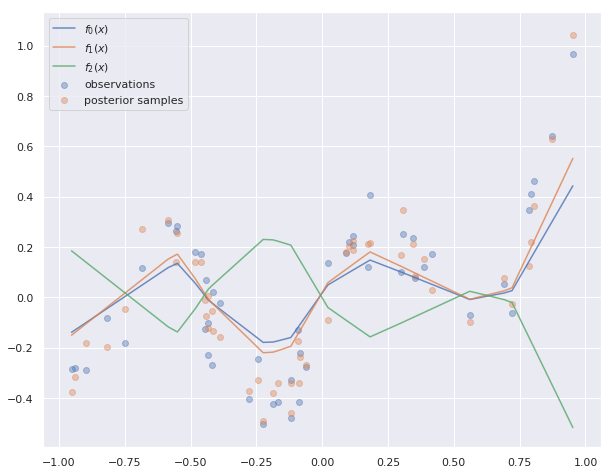

In [5]:
# Sample a, b ~ q(a, b)
n_samples = t.shape[0]
v = [stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab)) for _ in range(n_samples)]
v = torch.cat([vv[None, :] for vv in v],0)
a, b = ab_sample[:-1], ab_sample[-1:]
a = a.unsqueeze(1)

a = a.detach().cpu().numpy()
b = b.detach().cpu().numpy()

# plt.figure(figsize=(6, 6))
# plt.pcolor
# plt.scatter(a, b, s=5)
# plt.xlabel('a')
# plt.ylabel('b')
# plt.title('samples from q(a, b)')
# plt.gca().set_aspect('equal', 'datalim')  # equal aspect ratio
# plt.show()

# For each x_i, use samples a_i, b_i to compute predicted t_i
h_ = features(x).detach().numpy()
# Do weird shape stuff because now we have many samples of a and b (unlike during training)
post_samples = (np.expand_dims(h_, 1) @ a).flatten() + b.flatten() + (logvar/2).exp().detach().numpy() * np.random.randn(n_samples)
plt.figure(figsize=(10,8))
plt.scatter(x, t, alpha=0.4, label='observations')
plt.scatter(x, post_samples, alpha=0.4, label='posterior samples')
for i in range(h.shape[1]):
    plt.plot(x.numpy(), h_[:, i], alpha=0.8, label='$f_{}(x)$'.format(i))
# plt.plot(x.numpy(), p5.numpy(), '--', color=sns.color_palette()[1], label='95% posterior interval')
# plt.plot(x.numpy(), p95.numpy(), '--',color=sns.color_palette()[1])
plt.legend()
plt.show()

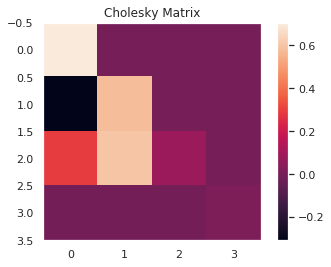

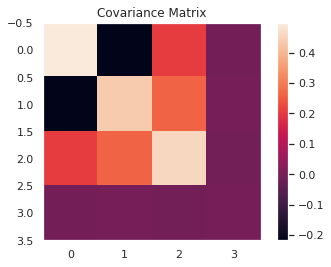

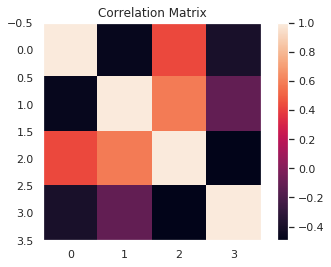

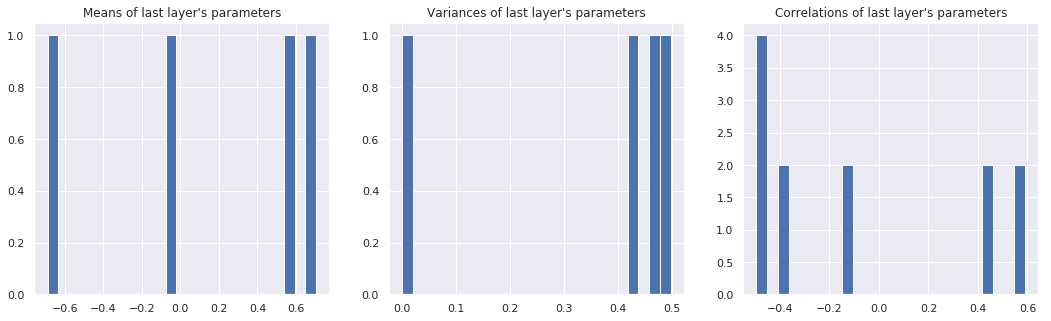

In [6]:
L = make_cholesky(logvar_ab, cov_ab).detach().cpu().numpy()
Cov = L @ L.T
inv_stds = np.diag(np.diag(Cov)**(-0.5))
Corr = inv_stds @ Cov @ inv_stds

plt.title("Cholesky Matrix"), plt.grid(False)
plt.imshow(L)
plt.colorbar()
plt.show()

plt.title("Covariance Matrix"), plt.grid(False)
plt.imshow(Cov)
plt.colorbar()
plt.show()

plt.title("Correlation Matrix"), plt.grid(False)
plt.imshow(Corr)
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Means of last layer's parameters")
plt.hist(mu_ab.detach(), bins=25)
plt.subplot(1, 3, 2)
plt.title("Variances of last layer's parameters")
plt.hist(np.diag(Cov), bins=25)
plt.subplot(1, 3, 3)
plt.title("Correlations of last layer's parameters")  # corr coefficients between pairs of DIFFERENT variables
correlations = Corr[~np.eye(Corr.shape[0], dtype=bool)]
plt.hist(correlations, bins=25)
plt.show()

estimated noise std: 0.0908 - true std: 0.1
Sample parameters 3 times from their posterior, and each time generate predictions using random noise with estimated variance.


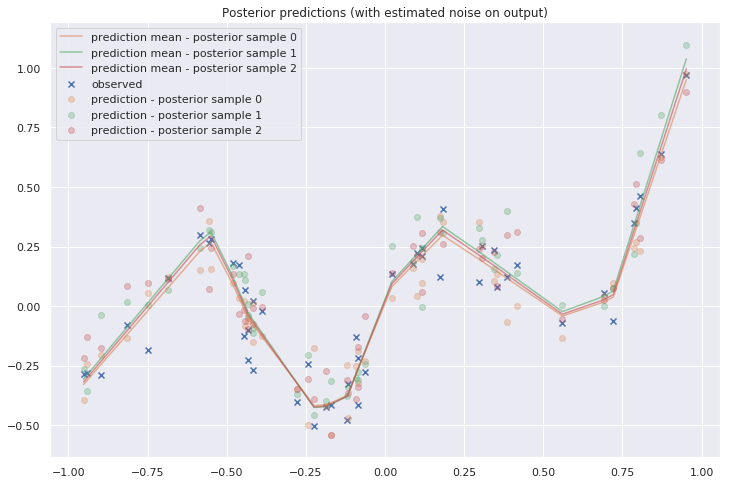

Posterior output mean 100 samples from q(a, b):


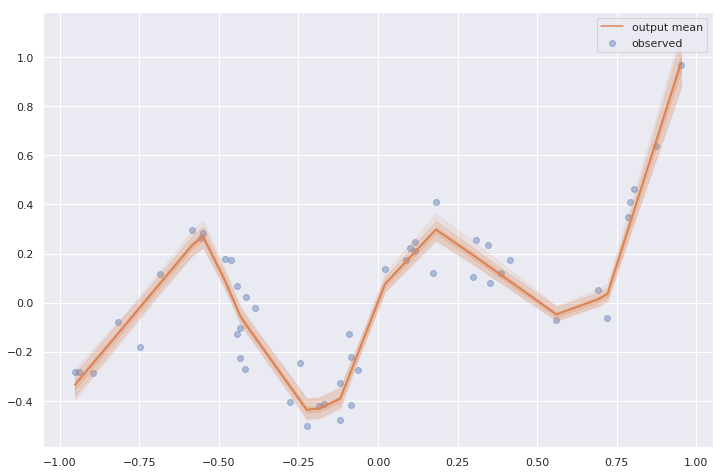

In [7]:
print('estimated noise std: {:.3g} - true std: {:.3g}'.format((logvar/2).exp().detach().numpy(), sigma))

n_samples = 3

print('Sample parameters {} times from their posterior, and each time generate predictions using random noise with estimated variance.'.format(n_samples))
plt.figure(figsize=(12, 8))
plt.title('Posterior predictions (with estimated noise on output)')
plt.scatter(x, t, marker='x', label='observed')
for s in range(n_samples):
    ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
    a, b = ab_sample[:-1], ab_sample[-1:]
    a = a.unsqueeze(1)

    a = a.detach().cpu().numpy()
    b = b.detach().cpu().numpy()

    h_ = features(x).detach().numpy()   # shape (N, 3)
    post_samples_mean = h_ @ a + b
    post_samples = post_samples_mean + (logvar/2).exp().detach().numpy() * np.random.randn(*x.shape)
    plt.scatter(x, post_samples, alpha=0.3, label='prediction - posterior sample {}'.format(s), color=sns.color_palette()[s+1])
    plt.plot(x.detach().cpu().numpy(), post_samples_mean, alpha=0.6, label='prediction mean - posterior sample {}'.format(s), color=sns.color_palette()[s+1])

plt.legend()
plt.show()


plt.figure(figsize=(12, 8))
plt.title('Posterior distribution of output mean (noiseless)')
plt.scatter(x, t, alpha=0.4, label='observed')
n_samples = 100
print("Posterior output mean {} samples from q(a, b):".format(n_samples))
post_samples_all = []
for s in range(n_samples):
    ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
    a, b = ab_sample[:-1], ab_sample[-1:]
    a = a.unsqueeze(1)

    a = a.detach().cpu().numpy()
    b = b.detach().cpu().numpy()

    h_ = features(x).detach().numpy()   # shape (N, 3)
    post_samples = h_ @ a + b   # noiseless
    post_samples_all.append(post_samples[None, :, 0])

x_np = x.squeeze(-1).detach().cpu().numpy()
post_samples_all = np.concatenate(post_samples_all, axis=0)
post_samples_mean = np.mean(post_samples_all, axis=0)
post_samples_perc = np.percentile(post_samples_all, [0.5, 2.5, 25, 75, 97.5, 99.5], axis=0)
# plt.plot(x_np, post_samples_mean, alpha=0.3, label='noiseless prediction')
plot(x_np, post_samples_mean, y_lower=post_samples_perc[0], y_upper=post_samples_perc[-1], 
     alpha=0.1, label='output mean', color=sns.color_palette()[1])
plot(x_np, post_samples_mean, y_lower=post_samples_perc[1], y_upper=post_samples_perc[-2], 
     alpha=0.2, color=sns.color_palette()[1])
plot(x_np, post_samples_mean, y_lower=post_samples_perc[2], y_upper=post_samples_perc[-3], 
     alpha=0.2, color=sns.color_palette()[1])

plt.legend()
plt.show()